In [8]:
import pandas as pd
import seaborn as sns

In [9]:
provider_info_df = pd.read_csv('NH_ProviderInfo_Jan2022.csv')
provider_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Data columns (total 96 columns):
 #   Column                                                                 Non-Null Count  Dtype  
---  ------                                                                 --------------  -----  
 0   Federal Provider Number                                                15238 non-null  object 
 1   Provider Name                                                          15238 non-null  object 
 2   Provider Address                                                       15238 non-null  object 
 3   Provider City                                                          15238 non-null  object 
 4   Provider State                                                         15238 non-null  object 
 5   Provider Zip Code                                                      15238 non-null  int64  
 6   Provider Phone Number                                                  15238 non-null 

In [10]:
provider_info_df.columns

Index(['Federal Provider Number', 'Provider Name', 'Provider Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Provider Phone Number', 'Provider SSA County Code',
       'Provider County Name', 'Ownership Type', 'Number of Certified Beds',
       'Average Number of Residents per Day',
       'Average Number of Residents per Day Footnote', 'Provider Type',
       'Provider Resides in Hospital', 'Legal Business Name',
       'Date First Approved to Provide Medicare and Medicaid Services',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council',
       'Automatic Sprinkler Systems in All Required Areas', 'Overall Rating',
       'Overall Rating Footnote', 'Health Inspection Rating',
       'Health Inspection Rating Footnote', 'QM Rating', 'QM Rating Footnote',
       'Lon

In [11]:
provider_info_df['Total Amount of Fines in Dollars'].describe()

count    1.523800e+04
mean     2.709004e+04
std      6.511422e+04
min      0.000000e+00
25%      0.000000e+00
50%      2.925000e+03
75%      2.182911e+04
max      1.115221e+06
Name: Total Amount of Fines in Dollars, dtype: float64

<AxesSubplot:xlabel='Total Amount of Fines in Dollars', ylabel='Count'>

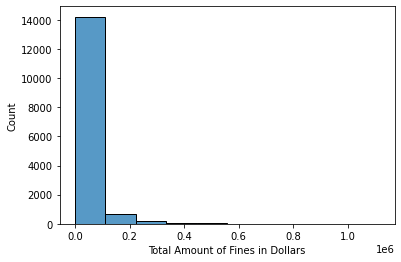

In [12]:
sns.histplot(provider_info_df['Total Amount of Fines in Dollars'], bins=10)

Probably a good opportunity to remove outliers later.

<AxesSubplot:xlabel='Total Amount of Fines in Dollars', ylabel='Count'>

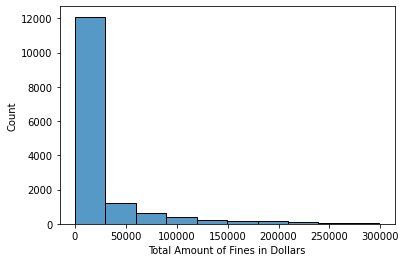

In [13]:
foo = provider_info_df[provider_info_df['Total Amount of Fines in Dollars'] < 300000]
sns.histplot(foo['Total Amount of Fines in Dollars'], bins=10)

In [14]:
provider_info_df['Average Number of Residents per Day Footnote'].value_counts()

10.0    73
Name: Average Number of Residents per Day Footnote, dtype: int64

In [15]:
provider_info_prepared_df = provider_info_df.drop(axis='columns', labels=[
    'Provider Address', 'Provider Phone Number', 'Provider County Name', 
    'Rating Cycle 1 Standard Survey Health Date', 'Rating Cycle 2 Standard Health Survey Date', 'Rating Cycle 3 Standard Health Survey Date',
    'Number of Fines', 'Total Number of Penalties', 'Location', 'Processing Date'
])

In [16]:
cat_cols = [
    'Provider City', 'Provider State', 'Provider Zip Code', 'Provider SSA County Code', 'Ownership Type', 'Provider Type', 'Provider Resides in Hospital', 
    'Continuing Care Retirement Community', 'Special Focus Status', 'Abuse Icon', 'Most Recent Health Inspection More Than 2 Years Ago', 
    'Provider Changed Ownership in Last 12 Months', 'With a Resident and Family Council', 'Automatic Sprinkler Systems in All Required Areas',
    'Long-Stay QM Rating Footnote', 'Short-Stay QM Rating Footnote', 'Staffing Rating Footnote', 'RN Staffing Rating Footnote', 'Reported Staffing Footnote', 
    'Physical Therapist Staffing Footnote', 'Total nursing staff turnover footnote', 'Registered Nurse turnover footnote', 'Administrator turnover footnote']
for cat_col in cat_cols:
    provider_info_df[cat_col] = provider_info_df[cat_col].astype('category')
provider_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15238 entries, 0 to 15237
Data columns (total 96 columns):
 #   Column                                                                 Non-Null Count  Dtype   
---  ------                                                                 --------------  -----   
 0   Federal Provider Number                                                15238 non-null  object  
 1   Provider Name                                                          15238 non-null  object  
 2   Provider Address                                                       15238 non-null  object  
 3   Provider City                                                          15238 non-null  category
 4   Provider State                                                         15238 non-null  category
 5   Provider Zip Code                                                      15238 non-null  category
 6   Provider Phone Number                                                  15238 n

In [17]:
provider_info_df.drop(axis='columns', labels=cat_cols).columns

Index(['Federal Provider Number', 'Provider Name', 'Provider Address',
       'Provider Phone Number', 'Provider County Name',
       'Number of Certified Beds', 'Average Number of Residents per Day',
       'Average Number of Residents per Day Footnote', 'Legal Business Name',
       'Date First Approved to Provide Medicare and Medicaid Services',
       'Overall Rating', 'Overall Rating Footnote', 'Health Inspection Rating',
       'Health Inspection Rating Footnote', 'QM Rating', 'QM Rating Footnote',
       'Long-Stay QM Rating', 'Short-Stay QM Rating', 'Staffing Rating',
       'RN Staffing Rating',
       'Reported Nurse Aide Staffing Hours per Resident per Day',
       'Reported LPN Staffing Hours per Resident per Day',
       'Reported RN Staffing Hours per Resident per Day',
       'Reported Licensed Staffing Hours per Resident per Day',
       'Reported Total Nurse Staffing Hours per Resident per Day',
       'Total number of nurse staff hours per resident per day on the week

In [18]:
num_cols = [
    'Number of Certified Beds', 'Average Number of Residents per Day', 'Overall Rating', 'Health Inspection Rating', 'QM Rating', 'Long-Stay QM Rating', 
    'Short-Stay QM Rating', 'Staffing Rating', 'RN Staffing Rating', 'Reported Nurse Aide Staffing Hours per Resident per Day',
    'Reported LPN Staffing Hours per Resident per Day', 'Reported RN Staffing Hours per Resident per Day', 'Reported Licensed Staffing Hours per Resident per Day',
    'Reported Total Nurse Staffing Hours per Resident per Day', 'Total number of nurse staff hours per resident per day on the weekend',
    'Registered Nurse hours per resident per day on the weekend', 'Reported Physical Therapist Staffing Hours per Resident Per Day',
    'Total nursing staff turnover', 'Registered Nurse turnover',  'Number of administrators who have left the nursing home',
    'Case-Mix Nurse Aide Staffing Hours per Resident per Day', 'Case-Mix LPN Staffing Hours per Resident per Day', 'Case-Mix RN Staffing Hours per Resident per Day',
    'Case-Mix Total Nurse Staffing Hours per Resident per Day', 'Adjusted Nurse Aide Staffing Hours per Resident per Day',
    'Adjusted LPN Staffing Hours per Resident per Day', 'Adjusted RN Staffing Hours per Resident per Day', 'Adjusted Total Nurse Staffing Hours per Resident per Day',
    'Rating Cycle 1 Total Number of Health Deficiencies', 'Rating Cycle 1 Number of Standard Health Deficiencies',
    'Rating Cycle 1 Number of Complaint Health Deficiencies', 'Rating Cycle 1 Health Deficiency Score', 'Rating Cycle 1 Number of Health Revisits',
    'Rating Cycle 1 Health Revisit Score', 'Rating Cycle 1 Total Health Score', 'Rating Cycle 2 Total Number of Health Deficiencies',
    'Rating Cycle 2 Number of Standard Health Deficiencies', 'Rating Cycle 2 Number of Complaint Health Deficiencies',
    'Rating Cycle 2 Health Deficiency Score', 'Rating Cycle 2 Number of Health Revisits', 'Rating Cycle 2 Health Revisit Score',
    'Rating Cycle 2 Total Health Score', 'Rating Cycle 3 Total Number of Health Deficiencies', 'Rating Cycle 3 Number of Standard Health Deficiencies',
    'Rating Cycle 3 Number of Complaint Health Deficiencies', 'Rating Cycle 3 Health Deficiency Score', 'Rating Cycle 3 Number of Health Revisits',
    'Rating Cycle 3 Health Revisit Score', 'Rating Cycle 3 Total Health Score', 'Total Weighted Health Survey Score', 'Number of Facility Reported Incidents',
    'Number of Substantiated Complaints', 'Number of Citations from Infection Control Inspections']



In [19]:
corr_matrix = provider_info_df.corr()
corr_matrix['Total Amount of Fines in Dollars'].sort_values(ascending=False)

Total Amount of Fines in Dollars                                         1.000000
QM Rating Footnote                                                       0.629352
Overall Rating Footnote                                                  0.623035
Health Inspection Rating Footnote                                        0.623035
Total Weighted Health Survey Score                                       0.575436
                                                                           ...   
Reported Total Nurse Staffing Hours per Resident per Day                -0.120308
Total number of nurse staff hours per resident per day on the weekend   -0.123379
Overall Rating                                                          -0.364900
Health Inspection Rating                                                -0.399633
Average Number of Residents per Day Footnote                                  NaN
Name: Total Amount of Fines in Dollars, Length: 62, dtype: float64

In [20]:
state_averages_df = pd.read_csv('NH_StateUSAverages_Jan2022.csv')
state_averages_df.head()

,State or Nation,Cycle 1 Total Number of Health Deficiencies,Cycle 1 Total Number of Fire Safety Deficiencies,Cycle 2 Total Number of Health Deficiencies,Cycle 2 Total Number of Fire Safety Deficiencies,Cycle 3 Total Number of Health Deficiencies,Cycle 3 Total Number of Fire Safety Deficiencies,Average Number of Residents per Day,Reported Nurse Aide Staffing Hours per Resident per Day,Reported LPN Staffing Hours per Resident per Day,...,Percentage of long stay residents who received an antianxiety or hypnotic medication,Percentage of high risk long stay residents with pressure ulcers,Percentage of long stay residents assessed and appropriately given the seasonal influenza vaccine,Percentage of short stay residents who made improvements in function,Percentage of short stay residents who were assessed and appropriately given the seasonal influenza vaccine,Percentage of short stay residents who were rehospitalized after a nursing home admission,Percentage of short stay residents who had an outpatient emergency department visit,Number of hospitalizations per 1000 long-stay resident days,Number of outpatient emergency department visits per 1000 long-stay resident days,Processing Date
0,NATION,8.1,4.4,8.4,4.6,8.1,4.3,76.1,2.19,0.88,...,19.669741,8.328548,95.825016,73.115406,78.789720,22.866740,10.489013,1.446098,0.794065,2022-01-01
1,AK,8.7,7.7,12.8,4.7,12.1,9.1,35.3,4.73,0.67,...,17.222425,6.497252,97.293507,76.823628,81.053333,15.731127,10.859274,0.711204,0.814816,2022-01-01
2,AL,2.9,3.0,3.0,3.3,4.0,3.5,87.6,2.20,0.90,...,24.154599,9.364816,93.862901,70.674791,79.280988,22.683458,11.068544,1.650541,0.810642,2022-01-01
3,AR,8.8,1.9,11.2,2.2,7.7,2.2,67.8,2.45,1.04,...,21.732916,8.835729,97.179128,77.538899,77.129412,24.420896,12.353823,1.888193,1.145363,2022-01-01
4,AZ,7.8,3.1,7.8,3.3,5.3,3.6,72.6,2.23,1.10,...,17.063047,9.175842,96.940522,72.479825,88.446259,23.891657,9.618150,1.284218,0.616814,2022-01-01


In [21]:
quality_mds_df = pd.read_csv('NH_QualityMsr_MDS_Jan2022.csv', low_memory=False)
quality_mds_df.head()

,Federal Provider Number,Provider Name,Provider Address,Provider City,Provider State,Provider Zip Code,Measure Code,Measure Description,Resident type,Q1 Measure Score,...,Q3 Measure Score,Footnote for Q3 Measure Score,Q4 Measure Score,Footnote for Q4 Measure Score,Four Quarter Average Score,Footnote for Four Quarter Average Score,Used in Quality Measure Five Star Rating,Measure Period,Location,Processing Date
0,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,401,Percentage of long-stay residents whose need f...,Long Stay,18.18182,...,18.18182,NaN,7.31707,NaN,14.792900,NaN,Y,2020Q4-2021Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2022-01-01
1,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,404,Percentage of long-stay residents who lose too...,Long Stay,4.65116,...,4.54545,NaN,6.66667,NaN,6.249999,NaN,N,2020Q4-2021Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2022-01-01
2,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,405,Percentage of low risk long-stay residents who...,Long Stay,NaN,...,NaN,9.0,NaN,9.0,70.000000,NaN,N,2020Q4-2021Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2022-01-01
3,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,406,Percentage of long-stay residents with a cathe...,Long Stay,0.00000,...,0.00000,NaN,0.00000,NaN,0.408016,NaN,Y,2020Q4-2021Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2022-01-01
4,015009,"BURNS NURSING HOME, INC.",701 MONROE STREET NW,RUSSELLVILLE,AL,35653,407,Percentage of long-stay residents with a urina...,Long Stay,2.17391,...,0.00000,NaN,0.00000,NaN,0.540540,NaN,Y,2020Q4-2021Q3,"701 MONROE STREET NW, RUSSELLVILLE, AL, 35653",2022-01-01


In [22]:
quality_mds_df.groupby('Federal Provider Number').mean().describe()

,Provider Zip Code,Measure Code,Q1 Measure Score,Footnote for Q1 Measure Score,Q2 Measure Score,Footnote for Q2 Measure Score,Q3 Measure Score,Footnote for Q3 Measure Score,Q4 Measure Score,Footnote for Q4 Measure Score,Four Quarter Average Score,Footnote for Four Quarter Average Score
count,15238.000000,15238.000000,15089.000000,11210.000000,14983.000000,10899.000000,15021.000000,10329.000000,15061.000000,10106.000000,15213.000000,3550.000000
mean,50311.652776,427.833333,33.305682,9.007604,32.562478,9.007065,32.324392,9.006336,32.239430,9.005407,32.248480,9.007836
std,26831.999192,0.000000,11.329891,0.082429,11.299390,0.083759,11.644837,0.077623,11.467476,0.069382,6.855735,0.081046
min,660.000000,427.833333,0.000000,9.000000,3.333334,9.000000,7.178492,9.000000,7.988708,9.000000,11.296867,9.000000
25%,29844.000000,427.833333,28.315001,9.000000,27.280738,9.000000,27.039895,9.000000,27.030347,9.000000,29.622148,9.000000
50%,48763.000000,427.833333,31.712132,9.000000,31.205199,9.000000,30.843332,9.000000,30.838759,9.000000,32.078950,9.000000
75%,72849.750000,427.833333,34.304320,9.000000,33.817242,9.000000,33.343014,9.000000,33.291236,9.000000,33.873496,9.000000
max,99929.000000,427.833333,100.000000,10.000000,100.000000,10.000000,100.000000,10.000000,100.000000,10.000000,100.000000,10.000000


In [26]:
import numpy as np
np.random.randn(5, 3)

array([[ 1.15708383,  0.32058664,  0.61950445],
       [-0.96624509, -1.31274871, -0.00519926],
       [ 0.58772317,  0.74975271,  0.18645765],
       [ 1.01404213, -1.64008769, -1.06671433],
       [-0.38787877, -0.11787718, -1.84470905]])